In [1]:
!pip install pandas numpy xgboost seaborn scipy scikit-learn matplotlib optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 6.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings
import optuna
import logging


In [87]:
class NumericalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, model=HistGradientBoostingRegressor()):
        self.model = model
        self.numerical_columns = None
        self.models = {}  # Ukládá jeden model pro každý sloupec

    def fit(self, X, y=None):
        X = X.copy()

        # Vybereme všechny číselné sloupce (i když mají hodnoty bez NaN)
        self.numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

        # Trénujeme modely pouze pro sloupce, které mají nějaké chybějící hodnoty
        for col in self.numerical_columns:
            if X[col].isna().sum() > 0:  # Pouze pro sloupce, které mají chybějící hodnoty
                X_features = X[self.numerical_columns].drop(columns=[col])
                mask = X[col].notna()

                X_train = X_features.loc[mask]
                y_train = X.loc[mask, col]

                if len(X_train) > 10:  # Pokud je dostatek dat pro trénink
                    model = clone(self.model)
                    model.fit(X_train, y_train)
                    self.models[col] = model

        return self

    def transform(self, X):
        X_copy = X.copy()

        # Pro každý sloupec, pokud má chybějící hodnoty, predikujeme chybějící hodnoty
        for col in self.numerical_columns:
            mask = X_copy[col].isna()  # Vytvoření masky pro chybějící hodnoty v daném sloupci
            if mask.sum() == 0:  # Pokud není žádná chybějící hodnota, nic nepredikujeme
                continue

            if col in self.models:  # Pokud byl model natrénován pro tento sloupec
                X_features = X_copy[self.numerical_columns].drop(columns=[col])
                X_missing = X_features.loc[mask]

                predicted = self.models[col].predict(X_missing)
                X_copy.loc[mask, col] = predicted

        return X_copy


In [4]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, model=HistGradientBoostingClassifier()):
        self.model = model
        self.categorical_columns = None
        self.models = {}

    def fit(self, X, y=None):
        X = X.copy()

        # Identifikace kategorických sloupců
        self.categorical_columns = X.select_dtypes(include=['object', 'category']).columns

        # Pro každý kategorický sloupec, kde jsou NaN, nahradíme je nejčastější kategorií
        for col in self.categorical_columns:
            # Pokud jsou NaN hodnoty v tomto sloupci
            if pd.isnull(X[col]).sum() > 0:
                # Nahradíme NaN nejčastější kategorií
                most_frequent = X[col].mode()[0]  # Určíme nejčastější kategorii
                X[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Pro každý kategorický sloupec, nahradíme NaN nejčastější kategorií
        for col in self.categorical_columns:
            if pd.isnull(X_copy[col]).sum() > 0:
                most_frequent = X_copy[col].mode()[0]  # Určíme nejčastější kategorii
                X_copy[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
        return X_copy

In [105]:
def evaluate_model(model, X_train, y_train, n_splits=3, seed=42):
    scores = []
    imputers = []
    encoders = []
    scalers = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx].copy()
        X_val = X_train.iloc[val_idx].copy()
        y_tr = y_train.iloc[train_idx].copy()
        y_val = y_train.iloc[val_idx].copy()

        # 🔧 Numerická imputace
        num_imputer = NumericalImputer().fit(X_tr)
        X_tr = num_imputer.transform(X_tr)
        X_val = num_imputer.transform(X_val)

        print("✅ Po numerické imputaci:")
        # print(X_tr.head())
        # print("Sloupce:", list(X_tr.columns))

        # 🔍 Zjištění kategoriálních sloupců
        categorical_columns = X_tr.select_dtypes(include=['object', 'category']).columns.tolist()
        print("Kategorie:", categorical_columns)

        # 🔧 Kategoriální imputace
        categorical_imputer = CategoricalImputer().fit(X_tr)
        X_tr = categorical_imputer.transform(X_tr)
        X_val = categorical_imputer.transform(X_val)

        # 🛡️ Kontrola na NaN/Inf pouze pro numerické sloupce
        numeric_columns = X_tr.select_dtypes(include=[np.number]).columns
        if (np.any(np.isnan(X_tr[numeric_columns])) or np.any(np.isinf(X_tr[numeric_columns])) or
            np.any(np.isnan(X_val[numeric_columns])) or np.any(np.isinf(X_val[numeric_columns])) or
            np.any(np.isnan(y_tr)) or np.any(np.isinf(y_tr)) or
            np.any(np.isnan(y_val)) or np.any(np.isinf(y_val))):
            print("⚠️ NaN/inf hodnoty — fold přeskočen")
            continue

        # 🔧 One-hot encoding
        existing_categorical_columns = [col for col in categorical_columns if col in X_tr.columns]
        if existing_categorical_columns:
            # Vytvoření encoderu pro kategorické sloupce
            encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

            # Aplikace One-Hot Encoding na trénovací a validační data
            X_tr_encoded = encoder.fit_transform(X_tr[existing_categorical_columns])
            X_val_encoded = encoder.transform(X_val[existing_categorical_columns])

            # Získání nových názvů sloupců po One-Hot Encoding
            encoded_columns = encoder.get_feature_names_out(existing_categorical_columns)

            # Drop původních kategorických sloupců a připojení nových one-hot sloupců
            X_tr = X_tr.drop(columns=existing_categorical_columns).reset_index(drop=True)
            X_val = X_val.drop(columns=existing_categorical_columns).reset_index(drop=True)

            # Vytvoření DataFrame pro one-hot sloupce a připojení je k původním datům
            X_tr_encoded_df = pd.DataFrame(X_tr_encoded, columns=encoded_columns)
            X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns)

            # Kombinace původních dat s novými one-hot encoded sloupci
            X_tr = pd.concat([X_tr, X_tr_encoded_df], axis=1)
            X_val = pd.concat([X_val, X_val_encoded_df], axis=1)

            encoders.append(encoder)

            print("✅ Po OneHotEncode:")
            # print(X_tr.head())
        else:
            print("ℹ️ Žádné kategoriální sloupce k one-hot encodingu.")
            encoders.append(None)

        # scaler = StandardScaler()
        # X_tr[numeric_columns] = scaler.fit_transform(X_tr[numeric_columns])
        # X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])

        # scalers.append(scaler)

        scaler = StandardScaler()

        print(X_tr.head())


        # 🔧 Trénink a evaluace
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        score = r2_score(y_val, preds)
        scores.append(score)
        imputers.append((num_imputer, categorical_imputer))

        print(f"📊 Skóre: {score}")
        print(f"🔍 Predikce: {preds[:5]}...")

    if not scores:
        print("⚠️ Žádné validní foldy (všechny selhaly)")
        return float("-inf"), None, None, None



    return np.mean(scores), imputers[-1][0], imputers[-1][1], encoders[-1], scaler



"""
def evaluate_model(model, X_train, y_train, n_splits=3, seed=42):
    scores = []
    imputers = []
    encoders = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx].copy()
        X_val = X_train.iloc[val_idx].copy()
        y_tr = y_train.iloc[train_idx].copy()
        y_val = y_train.iloc[val_idx].copy()


        num_imputer = NumericalImputer().fit(X_tr)
        X_tr = num_imputer.transform(X_tr)
        X_val = num_imputer.transform(X_val)


        print("columns_after_numimputer")
        print(X_tr.head())
        print(X_tr.columns)

        # scalling

        categorical_columns = X_tr.select_dtypes(include=['object', 'category']).columns

        print("categorical_columns")
        print(categorical_columns)

        categorical_imputer = CategoricalImputer().fit(X_tr)
        X_tr = categorical_imputer.transform(X_tr)
        X_val = categorical_imputer.transform(X_val)

        # Zkontrolujeme přítomnost NaN/inf hodnot
        #if (np.any(np.isnan(X_tr)) or np.any(np.isinf(X_tr)) or
        #    np.any(np.isnan(X_val)) or np.any(np.isinf(X_val)) or
        #    np.any(np.isnan(y_tr)) or np.any(np.isinf(y_tr)) or
        #    np.any(np.isnan(y_val)) or np.any(np.isinf(y_val))):
        #    print("⚠️ NaN/inf, nulové hodnoty!!!!")
        #    continue

        if (has_invalid_values(X_tr) or has_invalid_values(X_val) or
            has_invalid_values(y_tr) or has_invalid_values(y_val)):
            print("⚠️ NaN/inf, nulové hodnoty!!!!")
            continue



        if len(categorical_columns) > 0:
            encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            X_tr_encoded = encoder.fit_transform(X_tr[categorical_columns])
            X_val_encoded = encoder.transform(X_val[categorical_columns])

            # Připojíme one-hot kódované sloupce zpět k původním datům
            X_tr = X_tr.drop(columns=categorical_columns).reset_index(drop=True)
            X_val = X_val.drop(columns=categorical_columns).reset_index(drop=True)
            X_tr = pd.concat([X_tr, pd.DataFrame(X_tr_encoded)], axis=1)
            X_val = pd.concat([X_val, pd.DataFrame(X_val_encoded)], axis=1)

            print(X_tr.head())
            print(X_tr.columns)
            print(X_tr[categorical_columns])

        encoders.append(encoder)



        # Trénování modelu a predikce
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        score = r2_score(y_val, preds)
        scores.append(score)
        imputers.append((num_imputer, categorical_imputer))

        print(score)
        print(preds)

    if not scores:
        print("⚠️ No valid scores")
        return float("-inf"), None, None, None

    return np.mean(scores), imputers[-1][0], imputers[-1][1], encoders[-1] if encoders else None
"""

'\ndef evaluate_model(model, X_train, y_train, n_splits=3, seed=42):\n    scores = []\n    imputers = []\n    encoders = []\n    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)\n\n    for train_idx, val_idx in kf.split(X_train, y_train):\n        X_tr = X_train.iloc[train_idx].copy()\n        X_val = X_train.iloc[val_idx].copy()\n        y_tr = y_train.iloc[train_idx].copy()\n        y_val = y_train.iloc[val_idx].copy()\n\n\n        num_imputer = NumericalImputer().fit(X_tr)\n        X_tr = num_imputer.transform(X_tr)\n        X_val = num_imputer.transform(X_val)\n\n\n        print("columns_after_numimputer")\n        print(X_tr.head())\n        print(X_tr.columns)\n\n        # scalling\n\n        categorical_columns = X_tr.select_dtypes(include=[\'object\', \'category\']).columns\n\n        print("categorical_columns")\n        print(categorical_columns)\n\n        categorical_imputer = CategoricalImputer().fit(X_tr)\n        X_tr = categorical_imputer.transform(X_tr)\n

In [106]:
import xgboost as xgb
import numpy as np


def objective(trial, X_train, y_train):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000),  # více stromů pro stabilitu
    "max_depth": trial.suggest_int("max_depth", 4, 12),  # hlubší stromy, ale ne přehnaně
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),  # jemnější ladění
    "subsample": trial.suggest_float("subsample", 0.6, 1.0),  # bagging
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # random feature subset
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # regularizace
    "gamma": trial.suggest_float("gamma", 0, 5),  # další regularizace
    "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),  # L1 regularizace
    "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 5.0),  # L2 regularizace
    "tree_method": "hist",  # rychlé trénování
    "random_state": 42,
    "verbosity": 0,
    "n_jobs": -1
}

    print(f"Testing trial with params: {params}")

    try:
        model = xgb.XGBRegressor(**params)

        numerical_columns = X_train.select_dtypes(include=["number"]).columns

        score, num_imputer, cat_imputer, encoder, scaler = evaluate_model(model, X_train, y_train, n_splits=3)

        print(f"Score: {score}, type: {type(score)}") # debug code
        if np.isnan(score) or np.isinf(score):
            print(f"[Trial {trial.number}] Invalid score: {score}")
            return float("-inf")

        trial.set_user_attr("model", model)
        trial.set_user_attr("imputers", (num_imputer, cat_imputer))
        trial.set_user_attr("encoder", encoder)
        # trial.set_user_attr("scaler", scaler)

        print(f"[Trial {trial.number}] Done with score: {score}")
        return score

    except Exception as e:
        print(f"[Trial {trial.number}] Error: {e}")
        return float("-inf")


"""def objective(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "tree_method": "hist",
        "random_state": 42,
        "verbosity": 0,
        "n_jobs": -1
    }

    print(f"Testing trial with params: {params}")

    try:
        model = xgb.XGBRegressor(**params)

        numerical_columns = X_train.select_dtypes(include=["number"]).columns

        score, imputers = evaluate_model(model, X_train, y_train, n_splits=3)

        if np.isnan(score) or np.isinf(score):
            print(f"[Trial {trial.number}] Invalid score: {score}")
            return float("-inf")

        trial.set_user_attr("model", model)
        trial.set_user_attr("imputers", imputers)

        print(f"[Trial {trial.number}] Done with score: {score}")
        return score

    except Exception as e:
        print(f"[Trial {trial.number}] Error: {e}")
        return float("-inf")"""


'def objective(trial, X_train, y_train):\n    params = {\n        "n_estimators": trial.suggest_int("n_estimators", 50, 150),\n        "max_depth": trial.suggest_int("max_depth", 3, 8),\n        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),\n        "tree_method": "hist",\n        "random_state": 42,\n        "verbosity": 0,\n        "n_jobs": -1\n    }\n\n    print(f"Testing trial with params: {params}")\n\n    try:\n        model = xgb.XGBRegressor(**params)\n\n        numerical_columns = X_train.select_dtypes(include=["number"]).columns\n\n        score, imputers = evaluate_model(model, X_train, y_train, n_splits=3)\n\n        if np.isnan(score) or np.isinf(score):\n            print(f"[Trial {trial.number}] Invalid score: {score}")\n            return float("-inf")\n\n        trial.set_user_attr("model", model)\n        trial.set_user_attr("imputers", imputers)\n\n        print(f"[Trial {trial.number}] Done with score: {score}")\n        return score\n\n    exce

In [7]:
def remove_percentage_and_convert_column(df, column_name):
    df[column_name] = df[column_name].replace({'%': ''}, regex=True).astype(float) / 100
    return df

In [8]:
def extract_year(date_str):
    if pd.isna(date_str):
        return None

    if isinstance(date_str, float):
        return int(date_str)

    if isinstance(date_str, str):
        try:
            if "/" in date_str:
                return int(date_str.split("/")[-1])
            elif "-" in date_str:
                return int(date_str.split("-")[0])
            else:
                raise ValueError(f"Unknown date format: {date_str}")
        except Exception as e:
            print(f"Error processing date: {e}")
            return None
    else:
        return None


In [9]:

pd.set_option('display.max_columns', None)

In [136]:

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Data_X/listings.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

print(df.head())

       id                          listing_url       scrape_id last_scraped  \
0   23163   https://www.airbnb.com/rooms/23163  20250316041547   2025-03-16   
1   23169   https://www.airbnb.com/rooms/23169  20250316041547   2025-03-16   
2   26755   https://www.airbnb.com/rooms/26755  20250316041547   2025-03-16   
3  782440  https://www.airbnb.com/rooms/782440  20250316041547   2025-03-16   
4  782489  https://www.airbnb.com/rooms/782489  20250316041547   2025-03-16   

        source                                 name  \
0  city scrape         Residence Karolina - KAROL12   
1  city scrape           Residence Masna - Masna302   
2  city scrape    Central Prague Old Town Top Floor   
3  city scrape  Central,Cheap&Lovely Miniapartment2   
4  city scrape  Central,Cheap&Lovely Miniapartment3   

                                         description  \
0  Unique and elegant apartment rental in Prague,...   
1  Masna studio offers a lot of space and privacy...   
2  Big and beautiful new a

In [137]:
df["price"] = df["price"].replace(r"[\$,]", "", regex=True).astype(float)

In [138]:
print(df.describe(include="all"))

                  id                                       listing_url  \
count   1.010800e+04                                             10108   
unique           NaN                                             10108   
top              NaN  https://www.airbnb.com/rooms/1376687962067046501   
freq             NaN                                                 1   
mean    6.108089e+17                                               NaN   
std     5.380318e+17                                               NaN   
min     2.316300e+04                                               NaN   
25%     3.280956e+07                                               NaN   
50%     7.446005e+17                                               NaN   
75%     1.128376e+18                                               NaN   
max     1.376688e+18                                               NaN   

           scrape_id last_scraped       source  \
count   1.010800e+04        10108        10108   
unique     

In [139]:
df.drop_duplicates()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,23163,https://www.airbnb.com/rooms/23163,20250316041547,2025-03-16,city scrape,Residence Karolina - KAROL12,"Unique and elegant apartment rental in Prague,...",NaN,https://a0.muscache.com/pictures/01bbe32c-3f13...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.082290,14.415520,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,2.0,"[""Coffee maker"", ""Dishwasher"", ""Bed linens"", ""...",2918.0,1,365,1,7,60,731,1.4,663.6,NaN,t,0,0,0,0,2025-03-16,31,1,0,0,1,6,17508.0,2010-09-20,2024-06-15,4.90,4.83,5.00,5.00,4.97,4.93,4.86,NaN,t,70,69,0,0,0.18
1,23169,https://www.airbnb.com/rooms/23169,20250316041547,2025-03-16,city scrape,Residence Masna - Masna302,Masna studio offers a lot of space and privacy...,NaN,https://a0.muscache.com/pictures/b450cf2a-8561...,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Czechia","Hello, \r\nglad to see that you are interested...",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,72.0,82.0,"['email', 'phone']",t,t,NaN,Praha 1,NaN,50.088300,14.422720,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,2.0,"[""Patio or balcony"", ""Coffee maker"", ""Bed line...",NaN,1,365,1,7,60,731,1.2,710.6,NaN,t,7,13,13,13,2025-03-16,122,6,0,13,8,36,NaN,2010-05-07,2024-11-08,4.74,4.60,4.83,4.81,4.87,4.97,4.70,NaN,t,70,69,0,0,0.67
2,26755,https://www.airbnb.com/rooms/26755,20250316041547,2025-03-16,city scrape,Central Prague Old Town Top Floor,Big and beautiful new attic apartment in the v...,This apartment offers a fantastic location. Yo...,https://a0.muscache.com/pictures/miso/Hosting-...,113902,https://www.airbnb.com/users/show/113902,Daniel+Bea,2010-04-26,"Prague, Czechia",Hi! we are a sp/cz couple with 2 daughters (La...,within an hour,100%,98%,t,https://a0.muscache.com/im/pictures/user/8db01...,https://a0.muscache.com/im/pictures/user/8db01...,Staré Město,4.0,4.0,"['email', 'phone']",t,t,"Prague, Hlavní město Praha, Czechia",Praha 1,NaN,50.087290,14.431790,Entire rental unit,Entire home/apt,4,1.5,1.5 baths,1.0,2.0,"[""AC - split type ductless system"", ""Coffee ma...",1582.0,3,700,3,4,1125,1125,3.1,1125.0,NaN,t,3,7,24,173,2025-03-16,411,53,3,173,57,255,403410.0,2015-05-19,2025-03-07,4.94,4.95,4.92,4.93,4.96,4.93,4.90,NaN,f,3,3,0,0,3.43
3,782440,http

In [140]:
print(df.isnull().sum())

id                                                0
listing_url                                       0
scrape_id                                         0
last_scraped                                      0
source                                            0
                                               ... 
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                               975
Length: 79, dtype: int64


In [141]:
df["price"].describe()

,price
count,8808.000000
mean,2730.524977
std,8349.628162
min,223.000000
25%,1242.750000
50%,1762.000000
75%,2641.000000
max,251025.000000


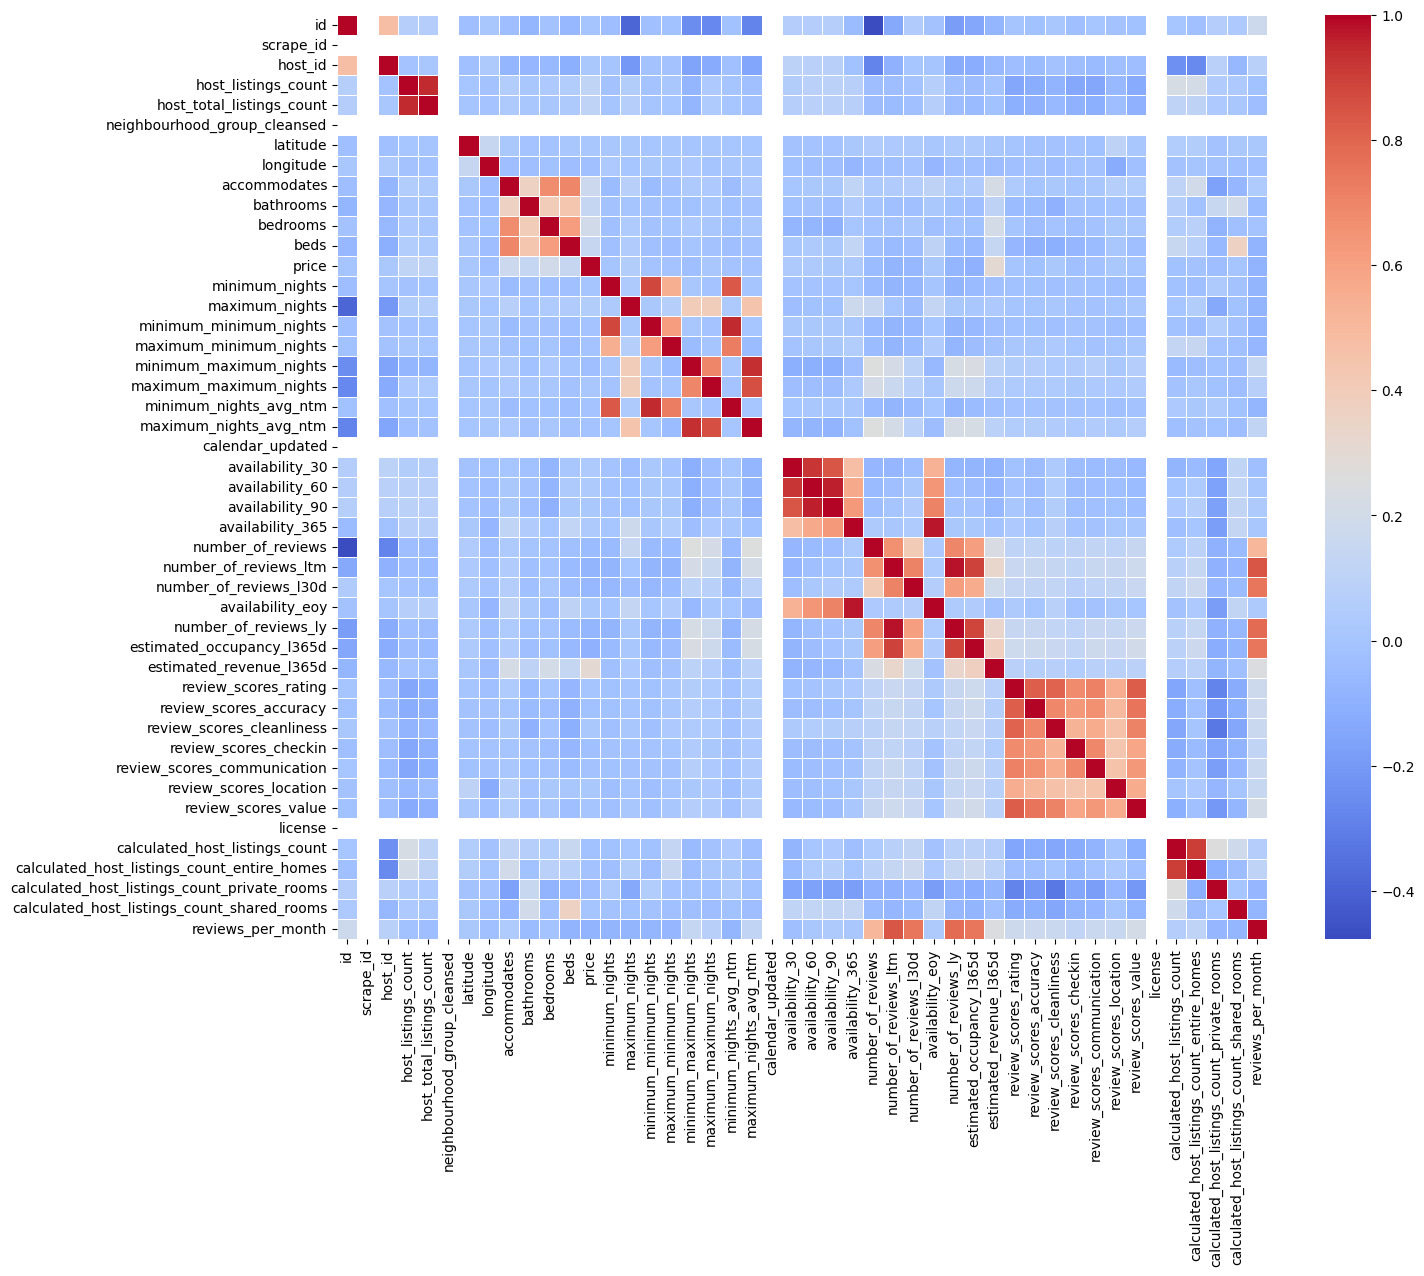

In [17]:
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.show()

In [18]:
df["neighbourhood"]

,neighbourhood
0,NaN
1,NaN
2,"Prague, Hlavní město Praha, Czechia"
3,NaN
4,NaN
...,...
10103,NaN
10104,NaN
10105,NaN
10106,NaN


In [142]:
#"first_review", "last_review",
drop_cols = [ "id", "name", "description", "license", "host_id", "host_name", "host_about", "neighborhood_overview", "neighbourhood_group_cleansed",
            "listing_url", "calendar_updated", "scrape_id", "last_scraped", "host_thumbnail_url", "neighbourhood", "listing_url", "picture_url", "host_url", "host_picture_url", "latitude","longitude", "calendar_last_scraped"
    ]

In [20]:
# drop_cols = id, listing_url, scrape_id, last_scraped, description, neighborhood_overview, picture_url, host_url, host_about,

#  host_thumbnail_url, host_picture_url, neighbourhood, neighbourhood_group_cleansed, latitude, longitude,

#  calendar_updated, license

In [143]:
df["first_review"].isna().sum()


np.int64(975)

In [144]:
#could make new columns from this column for instance: coffee machine 1/0
transform_columns = ["amenities"]

In [145]:
#host_thumbnail_url possibly getting user?
# "host_verifications", "host_has_profile_pic", host_identity_verified, has_availability, "instant_bookable"  binary
cat_columns = [ "host_url", "host_is_superhost", "host_verifications", "host_has_profile_pic", "host_identity_verified", "neighbourhood_cleansed" " property_type", "room_type", "bathrooms_text", "has_availability", "instant_bookable", "host_verifications", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"
    ]

In [146]:
#needs to be transformed to integer
perc_col = ["host_response_rate", "host_acceptance_rate"]

In [147]:
df = df.drop(columns = drop_cols, axis = 1)

In [148]:
#could include more old prices since its previous scrape
df["host_response_rate"]

,host_response_rate
0,100%
1,100%
2,100%
3,100%
4,100%
...,...
10103,94%
10104,100%
10105,NaN
10106,100%


In [149]:
for column in perc_col:
    df = remove_percentage_and_convert_column(df, column)

In [150]:
df['host_since'] = df['host_since'].apply(extract_year)
df['host_since'] = df['host_since'].astype('float64')
df['host_since']

,host_since
0,2008.0
1,2008.0
2,2010.0
3,2012.0
4,2012.0
...,...
10103,2019.0
10104,2015.0
10105,2025.0
10106,2021.0


In [151]:

new_columns =[
    "Coffee maker", "Bed linens", "Shampoo", "Heating", "Wifi",
    "Dishwasher", "Washer", "Wine glasses", "Pets allowed", "Patio or balcony"
]

for feature in new_columns:
    df[feature] = df['amenities'].apply(lambda x: 1 if feature in x else 0).astype("category")

df = df.drop("amenities", axis=1)
df.columns = df.columns.str.replace(" ", "")
df.columns

Index(['source', 'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'first_review', 'last_revi

In [152]:
numerical_columns = df.select_dtypes(include=["number"]).columns
# Odebereme sloupec "price"
numerical_columns = numerical_columns.drop("price", errors="ignore")
for col in numerical_columns:

    df[col] = df[col].astype('float64')

categorical_columns = df.select_dtypes(include=["object", "category"]).columns
for col in categorical_columns:
    df[col] = df[col].astype("category")

categorical_columns

Index(['source', 'host_location', 'host_response_time', 'host_is_superhost',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms_text', 'has_availability', 'first_review',
       'last_review', 'instant_bookable', 'Coffeemaker', 'Bedlinens',
       'Shampoo', 'Heating', 'Wifi', 'Dishwasher', 'Washer', 'Wineglasses',
       'Petsallowed', 'Patioorbalcony'],
      dtype='object')

In [ ]:


fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, 5 * len(numerical_columns)))


if len(numerical_columns) == 1:
    axes = [axes]


for i, col in enumerate(numerical_columns):

    sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue", ax=axes[i][0])
    axes[i][0].set_title(f"Histogram: {col}")


    sns.boxplot(y=df[col].dropna(), color="salmon", ax=axes[i][1])
    axes[i][1].set_title(f"Boxplot: {col}")


plt.tight_layout()
plt.show()

In [ ]:


# Vykreslení grafů pro každý kategorický sloupec
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], palette="coolwarm", order=df[col].value_counts().index)
    plt.xticks(rotation=45)  # Natočení popisků pro lepší čitelnost
    plt.title(f"Rozložení hodnot ve sloupci: {col}")
    plt.show()

In [153]:
df['price'] = df['price'].replace('NA', np.nan)

# Odstraníme řádky, kde je NaN nebo drobná hodnota (menší než 0.01)
df = df[~df['price'].isna()]
df = df[df['price'].apply(lambda x: abs(x) >= 0.01)]

In [154]:
X = df.drop("price",axis=1)
y = df["price"]

In [134]:
X.head()


,source,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Coffeemaker,Bedlinens,Shampoo,Heating,Wifi,Dishwasher,Washer,Wineglasses,Petsallowed,Patioorbalcony,host_verifications_flat
0,city scrape,2008.0,"Prague, Czechia",within an hour,1.0,1.00,t,Josefov,72.0,82.0,None,t,t,Praha 1,Entire rental unit,Entire home/apt,4.0,1.0,1 bath,1.0,2.0,1.0,365.0,1.0,7.0,60.0,731.0,1.4,663.6,t,0.0,0.0,0.0,0.0,31.0,1.0,0.0,0.0,1.0,6.0,17508.0,2010-09-20,2024-06-15,4.90,4.83,5.00,5.00,4.97,4.93,4.86,t,70.0,69.0,0.0,0.0,0.18,1,1,1,1,1,1,1,0,0,0,email_phone
2,city scrape,2010.0,"Prague, Czechia",within an hour,1.0,0.98,t,Staré Město,4.0,4.0,None,t,t,Praha 1,Entire rental unit,Entire home/apt,4.0,1.5,1.5 baths,1.0,2.0,3.0,700.0,3.0,4.0,1125.0,1125.0,3.1,1125.0,t,3.0,7.0,24.0,173.0,411.0,53.0,3.0,173.0,57.0,255.0,403410.0,2015-05-19,2025-03-07,4.94,4.95,4.92,4.93,4.96,4.93,4.90,f,3.0,3.0,0.0,0.0,3.43,1,1,1,1,1,1,0,1,0,0,email_phone
3,city scrape,2012.0,"Prague, Czechia",within an hour,1.0,0.80,t,Žižkov,6.0,6.0,None,t,t,Praha 3,Private room in rental unit,Private room,2.0,1.0,1 private bath,1.0,2.0,3.0,60.0,1.0,3.0,60.0,60.0,3.0,60.0,t,5.0,5.0,5.0,5.0,414.0,52.0,5.0,5.0,52.0,255.0,219300.0,2013-01-04,2025-03-02,4.76,4.85,4.71,4.94,4.95,4.63,4.83,f,6.0,3.0,3.0,0.0,2.79,1,1,1,1,0,0,0,0,0,0,email_phone
4,city scrape,2012.0,"Prague, Czechia",within an hour,1.0,0.80,t,Žižkov,6.0,6.0,None,t,t,Praha 3,Private room in rental unit,Private room,2.0,1.0,1 private bath,1.0,3.0,3.0,60.0,3.0,3.0,60.0,60.0,3.0,60.0,t,3.0,3.0,3.0,3.0,389.0,47.0,3.0,3.0,48.0,255.0,160395.0,2013-03-25,2025-03-01,4.69,4.79,4.58,4.89,4.90,4.59,4.73,f,6.0,3.0,3.0,0.0,2.67,1,1,1,1,0,0,0,0,0,0,email_phone
5,city scrape,2012.0,"Prague, Czechia",within an hour,1.0,0.80,t,Žižkov,6.0,6.0,None,t,t,Praha 3,Private room in rental unit,Private room,2.0,1.0,1 private bath,1.0,1.0,3.0,60.0,3.0,3.0,60.0,60.0,3.0,60.0,t,6.0,6.0,6.0,6.0,381.0,52.0,2.0,6.0,53.0,255.0,196860.0,2013-02-06,2025-02-23,4.78,4.90,4.64,4.91,4.93,4.68,4.81,f,6.0,3.0,3.0,0.0,2.58,1,1,1,1,0,0,0,0,0,0,email_phone


In [156]:
X.columns = X.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)


In [157]:
def flatten_verifications(x):
    if pd.isnull(x):
        return None
    try:
        items = ast.literal_eval(x)
        return "_".join(sorted(items))  # třeba 'email_phone' nebo 'phone_email'
    except:
        return None

In [158]:
import ast

def clean_verifications(val):
    if pd.isnull(val):
        return None
    # Použijeme ast.literal_eval pro bezpečné vyhodnocení seznamu
    try:
        items = ast.literal_eval(val)
        if isinstance(items, list):
            return "_".join(sorted(items))  # Seřadíme a spojíme s "_"
    except:
        return None

X['host_verifications'] = X['host_verifications'].apply(clean_verifications)
X['host_verifications']


,host_verifications
0,email_phone
2,email_phone
3,email_phone
4,email_phone
5,email_phone
...,...
10103,email_phone
10104,email_phone
10105,phone
10106,email_phone


In [159]:
for col in numerical_columns:
    X[col] = X[col].replace('NA', np.nan)
print(X.isnull().sum())


source                   0
host_since               1
host_location         1987
host_response_time     562
host_response_rate     562
                      ... 
Dishwasher               0
Washer                   0
Wineglasses              0
Petsallowed              0
Patioorbalcony           0
Length: 66, dtype: int64


In [37]:
len(X.columns)

66

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle = True)

In [168]:
def transform_with_best_pipeline(X_trans, num_imputer, cat_imputer, encoder, scaler, X_train_columns):
    # 1️⃣ Numerická imputace
    X_trans = num_imputer.transform(X_trans)

    # 2️⃣ Kategoriální imputace
    X_trans = cat_imputer.transform(X_trans)

    # 3️⃣ One-hot encoding
    if encoder:
        # Vybere pouze kategorické sloupce podle typu
        categorical_columns = [col for col in X_trans.columns if X_trans[col].dtype in ['object', 'category']]

        # One-Hot Encoding
        if categorical_columns:
            X_encoded = encoder.transform(X_trans[categorical_columns])

            # Odstranit původní kategorické sloupce
            X_trans = X_trans.drop(columns=categorical_columns).reset_index(drop=True)

            # Získání názvů nových sloupců (feature names) z OneHotEncoderu
            new_columns = encoder.get_feature_names_out(categorical_columns)

            # Převeďme na DataFrame s těmito názvy
            X_encoded_df = pd.DataFrame(X_encoded, columns=new_columns)

            # Spojení původních dat s nově vytvořenými sloupci
            X_trans = pd.concat([X_trans.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)




    # 4️⃣ Škálování jen numerických typů (int/float)
    # if scaler:
    #     numeric_cols = X_trans.select_dtypes(include=np.number).columns
    #     X_trans[numeric_cols] = scaler.transform(X_trans[numeric_cols])

    return X_trans


In [ ]:
from functools import partial


optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize')
optuna_objective = partial(objective, X_train=X_train, y_train=y_train)
study.optimize(optuna_objective, timeout=500, show_progress_bar=True)


# Získání nejlepšího modelu a imputérů
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]
num_imputer = best_trial.user_attrs["imputers"][0]
cat_imputer = best_trial.user_attrs["imputers"][1]
encoder = best_trial.user_attrs.get("encoder")
# scaler = best_trial.user_attrs.get("scaler")



[I 2025-04-19 20:46:47,196] A new study created in memory with name: no-name-0f72c5ac-640c-4c9f-b789-f54607808ee4


   0%|          | 00:00/08:20

Testing trial with params: {'n_estimators': 308, 'max_depth': 9, 'learning_rate': 0.018122351483363743, 'subsample': 0.7929783734154349, 'colsample_bytree': 0.6259793076962866, 'min_child_weight': 2, 'gamma': 4.337345957250017, 'reg_alpha': 0.659187821123035, 'reg_lambda': 1.7406068618700834, 'tree_method': 'hist', 'random_state': 42, 'verbosity': 0, 'n_jobs': -1}
✅ Po numerické imputaci:
Kategorie: ['source', 'host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'first_review', 'last_review', 'instant_bookable', 'Coffeemaker', 'Bedlinens', 'Shampoo', 'Heating', 'Wifi', 'Dishwasher', 'Washer', 'Wineglasses', 'Petsallowed', 'Patioorbalcony']


<ipython-input-4-d8ed602dedf5>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
<ipython-input-4-d8ed602dedf5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Výstupní stream byl oříznut na posledních 5000 řádků.
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   first_review_2017-06-20  first_review_2017-06-21  first_review_2017-06-22  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   first_review_2017-06-24  first_review_2017-06-25  first_review_2017-06-27  \
0                      0.0                      0.0             

<ipython-input-4-d8ed602dedf5>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
<ipython-input-4-d8ed602dedf5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

✅ Po numerické imputaci:
Kategorie: ['source', 'host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'first_review', 'last_review', 'instant_bookable', 'Coffeemaker', 'Bedlinens', 'Shampoo', 'Heating', 'Wifi', 'Dishwasher', 'Washer', 'Wineglasses', 'Petsallowed', 'Patioorbalcony']


<ipython-input-4-d8ed602dedf5>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
<ipython-input-4-d8ed602dedf5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Výstupní stream byl oříznut na posledních 5000 řádků.
4                      0.0                      0.0                      0.0   

   first_review_2017-07-01  first_review_2017-07-02  first_review_2017-07-03  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   first_review_2017-07-05  first_review_2017-07-08  first_review_2017-07-09  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0             

<ipython-input-4-d8ed602dedf5>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
<ipython-input-4-d8ed602dedf5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Výstupní stream byl oříznut na posledních 5000 řádků.
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   first_review_2017-06-20  first_review_2017-06-21  first_review_2017-06-22  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   first_review_2017-06-24  first_review_2017-06-25  first_review_2017-06-27  \
0                      0.0                      0.0             

<ipython-input-4-d8ed602dedf5>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
<ipython-input-4-d8ed602dedf5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

✅ Po numerické imputaci:
Kategorie: ['source', 'host_location', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 'first_review', 'last_review', 'instant_bookable', 'Coffeemaker', 'Bedlinens', 'Shampoo', 'Heating', 'Wifi', 'Dishwasher', 'Washer', 'Wineglasses', 'Petsallowed', 'Patioorbalcony']


<ipython-input-4-d8ed602dedf5>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN
<ipython-input-4-d8ed602dedf5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

Výstupní stream byl oříznut na posledních 5000 řádků.
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   first_review_2017-06-27  first_review_2017-06-29  first_review_2017-06-30  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   first_review_2017-07-01  first_review_2017-07-02  first_review_2017-07-03  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0             

In [79]:
if not hasattr(num_imputer, 'transform') or not hasattr(cat_imputer, 'transform'):
    raise ValueError("Provided imputers are not valid transformers")


In [170]:
scale = None
X_test_transformed = transform_with_best_pipeline(X_test, num_imputer, cat_imputer, encoder, scaler, X_train.columns)
y_pred = best_trial.user_attrs["model"].predict(X_test_transformed)
y_pred

<ipython-input-4-d8ed602dedf5>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_copy[col].fillna(most_frequent, inplace=True)  # Nahradíme NaN


array([ 2718.094 , -6827.6104,  1377.1302, ...,  2329.0386,  1095.6917,
        2401.113 ], dtype=float32)

In [172]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Výpočet MAE
mae = mean_absolute_error(y_test, y_pred)

# Výpočet MAPE (pouze pro nenulové hodnoty v y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Výpočet R²
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R² (koeficient determinace): {r2}")


Mean Absolute Error (MAE): 1197.189979614654
Mean Absolute Percentage Error (MAPE): 41.523220396003964%
R² (koeficient determinace): 0.6059628838943776


In [ ]:
X_train.columns

In [ ]:
print(X_test.head())

In [ ]:
X_train = outlier_remover(X, X_train)

In [ ]:
numerical_imputer = NumericalImputer()
categorical_imputer = CategoricalImputer()

print(X_train.isnull().sum())
print(X_test.isnull().sum())